# In this Notebook we are attempting to predict if a person will win their next fight depending on how they performed on their last 5 fights

## Library Imports

In [1]:
import sys
sys.path.insert(1, '../combined_data')
sys.path.insert(1, '../predict_winner')
from make_career import make_career
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import talos as ta
from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import matplotlib.pyplot as plt
score_cols = ['precision', 'recall', 'fbeta_score', 'support']

Using TensorFlow backend.


## Loading the dataset

In [2]:
features, labels = make_career(N_FIGHT_CAREER=5)
labels = labels.reshape(-1,)

Creating careers using 5 fight intervals and predicting 1 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)

Features shape: (3220, 5)
Labels shape: (3220, 1)

Features is a 2D matrix with 3220 rows
Each row contains has 5 fights, and each fight has 100 keys

Labels is a 2D matrix with 3220 rows
Each row contains the the prediction for the next 1 fight(s)


In [3]:
print(features.shape)
print(type(features))

(3220, 5)
<class 'numpy.ndarray'>


In [4]:
print(labels.shape)
print(type(labels))

(3220,)
<class 'numpy.ndarray'>


## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [12]:
from sklearn.utils import shuffle

def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.90)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
    print("X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

### Generates np.array of shape (3220, 5, win?)

## Building a DNN to predict the winner using last n fights

In [32]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)


In [33]:
# Define hyperparameters to use in Grid Search
dnn_params = {'lr': [0.01, 1, 2],
     'first_neuron': [128, 256],
     'hidden_layers': [1, 2],
     'batch_size': [64, 128, 256],
     'epochs': [10, 25],
     'dropout': [0.01, 0.1],
     'optimizer': [Adam],
     'shapes':['funnel'],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [34]:
# Create the Neural Network
dnn_model = ta.Scan(x=X_train,
               y=y_train,
               model=get_dnn,
               params=dnn_params,
               experiment_name="UFC_5_Fight_Predictor")


100%|██████████| 144/144 [05:50<00:00,  2.43s/it]


In [35]:
results_df = dnn_model.data
print(results_df.shape, len(dnn_scores))
dnn_cols = list(results_df.columns)

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in dnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = dnn_scores[index][score_index]
        
    new_df_data.append(new_row)

dnn_df = pd.DataFrame(new_df_data)

(144, 16) 144


In [65]:
dnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses'], inplace=True)
top_5_val_dnn = dnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_acc_dnn = dnn_df.sort_values(by=['accuracy'], ascending=False).head(5)
top_5_val_dnn.to_csv('../model_results/UFC_Predict_5_Fights_DNN.csv')

In [66]:
top_5_val_dnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,first_neuron,hidden_layers,lr,shapes,precision,recall,fbeta_score
91,25,0.895920,0.595402,0.378377,0.852071,128,0.10,25,256,1,1.0,funnel,0.617323,0.782435,0.690141
100,10,0.775785,0.590805,0.539317,0.629191,256,0.01,10,128,2,1.0,funnel,0.594034,0.914172,0.720126
121,10,0.695559,0.588506,0.656358,0.646450,256,0.10,10,128,1,1.0,funnel,0.602289,0.840319,0.701667
142,25,0.983496,0.587356,0.389867,0.865878,256,0.10,25,256,2,1.0,funnel,0.611285,0.778443,0.684811
1,10,0.738394,0.587356,0.603905,0.694773,64,0.01,10,128,1,1.0,funnel,0.601140,0.842315,0.701579


## Building a CNN to predict the winner using last n fights

In [67]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


In [45]:
# Define hyperparameters to use in Grid Search
cnn_params = {'lr': [0.01, 0.1, 1],
     'num_filters': [64, 128],
     'kernel_size': [2],
     'batch_size': [64, 128],
     'epochs': [5, 15],
     'dropout': [0.01],
     'flatten_layer': [100, 150], 
     'optimizer': [Adam],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [46]:
# Create the Neural Network
cnn_model = ta.Scan(x=X_train,
                y=y_train,
                model=get_cnn,
                params=cnn_params,
                experiment_name="UFC_5_Fight_Predictor_CNN")



  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:01<01:09,  1.47s/it]

  4%|▍         | 2/48 [00:03<01:09,  1.51s/it]

  6%|▋         | 3/48 [00:05<01:15,  1.68s/it]

  8%|▊         | 4/48 [00:07<01:18,  1.79s/it]

 10%|█         | 5/48 [00:09<01:18,  1.83s/it]

 12%|█▎        | 6/48 [00:10<01:15,  1.80s/it]

 15%|█▍        | 7/48 [00:12<01:12,  1.78s/it]

 17%|█▋        | 8/48 [00:14<01:13,  1.84s/it]

 19%|█▉        | 9/48 [00:16<01:09,  1.79s/it]

 21%|██        | 10/48 [00:18<01:13,  1.95s/it]

 23%|██▎       | 11/48 [00:20<01:10,  1.91s/it]

 25%|██▌       | 12/48 [00:23<01:17,  2.14s/it]

 27%|██▋       | 13/48 [00:26<01:27,  2.50s/it]

 29%|██▉       | 14/48 [00:29<01:36,  2.83s/it]

 31%|███▏      | 15/48 [00:33<01:38,  2.97s/it]

 33%|███▎      | 16/48 [00:37<01:42,  3.20s/it]

 35%|███▌      | 17/48 [00:39<01:35,  3.07s/it]

 38%|███▊      | 18/48 [00:44<01:42,  3.42s/it]

 40%|███▉      | 19/48 [00:47<01:43,  3.55s/it]

 42%|████▏     | 20/48 [00:51<01:39,

In [48]:
results_df = cnn_model.data
cnn_cols = list(results_df.columns)
print(results_df.shape, len(cnn_scores))

new_df_data = []

for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in cnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = cnn_scores[index][score_index]
        
    new_df_data.append(new_row)

cnn_df = pd.DataFrame(new_df_data)

(48, 16) 48


In [68]:
cnn_df.drop(columns=['activation', 'last_activation', 'optimizer', 'support', 'losses'], inplace=True)
top_5_val_cnn = cnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_acc_cnn = cnn_df.sort_values(by=['accuracy'], ascending=False).head(5)
top_5_val_cnn.to_csv('../model_results/UFC_Predict_5_Fights_CNN.csv')

In [69]:
top_5_val_cnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,epochs,flatten_layer,kernel_size,lr,num_filters,precision,recall,fbeta_score
4,5,0.740139,0.594253,0.502339,0.775148,64,0.01,5,100,2,1.0,64,0.625616,0.752964,0.683408
9,5,0.678880,0.586207,0.629811,0.653846,64,0.01,5,150,2,0.1,128,0.600829,0.859684,0.707317
27,5,0.678796,0.586207,0.643905,0.634615,128,0.01,5,100,2,0.1,128,0.603693,0.839921,0.702479
33,5,0.682159,0.585057,0.642174,0.626233,128,0.01,5,150,2,0.1,128,0.600000,0.859684,0.706742
41,15,1.521602,0.580460,0.023210,0.998521,128,0.01,15,100,2,1.0,128,0.632768,0.664032,0.648023


## Building an LSTM to predict the winner using last n fights

In [52]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


Train on 2898 samples, validate on 322 samples
Epoch 1/30
2898/2898 [==============================] - 1s 266us/step - loss: 0.7006 - accuracy: 0.5500 - val_loss: 0.6769 - val_accuracy: 0.5870
Epoch 2/30
2898/2898 [==============================] - 0s 111us/step - loss: 0.6515 - accuracy: 0.6166 - val_loss: 0.6904 - val_accuracy: 0.5683
Epoch 3/30
2898/2898 [==============================] - 0s 125us/step - loss: 0.6200 - accuracy: 0.6618 - val_loss: 0.7020 - val_accuracy: 0.5466
Epoch 4/30
2898/2898 [==============================] - 0s 156us/step - loss: 0.5889 - accuracy: 0.6884 - val_loss: 0.7220 - val_accuracy: 0.5559
Epoch 5/30
2898/2898 [==============================] - 0s 153us/step - loss: 0.5475 - accuracy: 0.7274 - val_loss: 0.7687 - val_accuracy: 0.5683
Epoch 6/30
2898/2898 [==============================] - 0s 171us/step - loss: 0.4762 - accuracy: 0.7750 - val_loss: 0.7968 - val_accuracy: 0.5248
Epoch 7/30
2898/2898 [==============================] - 0s 158us/step - loss:

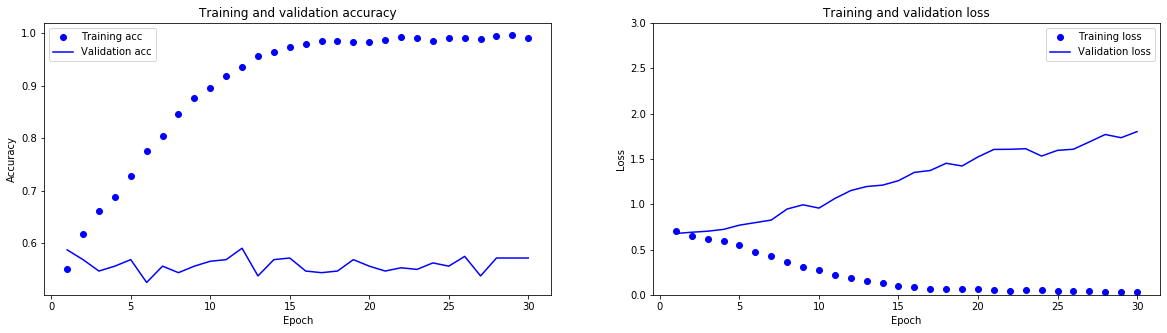

In [55]:
history, model = get_lstm(X_train, y_train, X_test, y_test, test_model=True)

In [76]:
hist = history.history
lstm_data = [hist['accuracy'][-1], hist['val_accuracy'][-1], hist['loss'][-1], hist['val_loss'][-1]]
lstm_data = lstm_data + [lstm_scores[0][0], lstm_scores[0][1], lstm_scores[0][2], lstm_scores[0][3]]
lstm_cols = ['accuracy', 'val_accuracy', 'loss', 'val_loss'] + score_cols


lstm_df = pd.DataFrame(data=[lstm_data], columns=lstm_cols)
lstm_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
lstm_df

,accuracy,val_accuracy,loss,val_loss,precision,recall,fbeta_score,support
0,0.990338,0.571429,0.034902,1.801207,0.604061,0.661111,0.6313,None


In [77]:
lstm_df.to_csv('../model_results/UFC_Predict_5_Fights_LSTM.csv')

# Model Builders

In [47]:
# Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

### Analyzing last n fights using an LSTM

In [51]:
lstm_scores = []

def get_lstm(x_train, y_train, x_val, y_val, test_model=False):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape=(5, 97),
                   recurrent_dropout=0.2)) #, return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", 
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=64,
                       epochs=30,
                       verbose=1)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    lstm_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

### Analyzing last n fights using a Dense Neural Network

In [26]:
dnn_scores = []

def get_dnn(x_train, y_train, x_val, y_val, params, test_model=False):
    
    model = Sequential()
    # Input Layer
    model.add(Dense(params["first_neuron"], 
                    activation=params['activation'], 
                    input_dim=X_train.shape[1]))
    
    model.add(Dropout(params['dropout']))
    
    # Hidden Layers
    hidden_layers(model, params, 1)
    
    # Output Layers
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
                  
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    dnn_scores.append(score)
    
    if test_model:
        model.summary()
        plot_training_results(history)
        

    return history, model

### Analyzing last n fights using a Convolutional Neural Network

In [27]:
cnn_scores = []

def get_cnn(x_train, y_train, x_val, y_val, params, test_model=False):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu', input_shape=(5, 97)))
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu'))
    model.add(Dropout(params['dropout']))
#     model.add(MaxPooling1D(pool_size=2))
    
    # Flatten Layers
    model.add(Flatten())
    model.add(Dense(params["flatten_layer"], activation='relu'))
#     model.add(Dense(params["flatten_layer"], activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    cnn_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

## Helper Functions

In [28]:
def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()

## Extract numerical and categorical columns

In [29]:
# Get the first fight window and the first fight in that window
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols

In [30]:
x, y = get_column_types()

In [31]:
cnn_df = pd.DataFrame(data=cnn_scores, columns=cols)
dnn_df = pd.DataFrame(data=dnn_scores, columns=cols)
lstm_df = pd.DataFrame(data=lstm_scores, columns=cols)


speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]

index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                'lifespan': lifespan}, index=index)
>>> ax = df.plot.bar(rot=0)

SyntaxError: invalid syntax (<ipython-input-31-1672e73c44c6>, line 13)